## Домашнее задание №8.
### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Авторы: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), Горохов Олег

Ваша основная задача: научиться генерировать стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [70]:
# Не меняйте блок кода ниже! Здесь указаны все необходимые import-ы
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
%matplotlib inline
# __________end of block__________

In [71]:
# Не меняйте блок кода ниже!
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [72]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/onegin_hw07.txt -O ./onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text]) # Убираем лишние символы табуляций, приводим все буквы к нижнему регистру
# __________end of block__________

--2024-12-01 15:32:41--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/onegin_hw07.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘./onegin.txt’

./onegin.txt        100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-12-01 15:32:41 (8.64 MB/s) - ‘./onegin.txt’ saved [262521/262521]



Выведем несколько первых символов входного текста. Видим, что символы табуляций удалены, буквы приведены к нижнему регистру. Символы \n мы оставляем - чтобы научить сеть генерировать символ \n, когда нужно перейти на новую строку.

In [73]:
text[:36]

'\ni\n\n«мой дядя самых честных правил,\n'

#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим технический токен `<sos>`.

In [74]:
# Не меняйте блок кода ниже!
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>'] # Строим множество всех токенов-символов и добавляем к нему служебный токен <sos>
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)} # Строим словарь с ключами-токенами и значениями-индексами в списке токенов
idx_to_token = {idx: x for idx, x in enumerate(tokens)} # Строим обратный словарь (чтобы по индексу можно было получить токен)

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")


text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятия №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [75]:
# Не меняйте код ниже
# __________start of block__________
batch_size = 256 # Размер батча. Батч - это набор последовательностей символов.
seq_length = 100 # Максимальная длина одной последовательности символов в батче
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>'] # Добавляем в начало каждой строки технический символ - для определения начального состояния сети

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1) # Случайным образом выбираем индекс начального символа в батче
    # Строим непрерывный батч.
    # Для этого выбираем в исходном тексте подпоследовательность, которая начинается с индекса start_index и имеет размер batch_size*seq_length.
    # Затем мы делим эту подпоследовательность на batch_size последовательностей размера seq_length. Это и будет батч, матрица размера batch_size*seq_length.
    # В каждой строке матрицы будут указаны индексы
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [76]:
next(generate_chunk())

array([[83, 54,  7, ..., 54,  1, 48],
       [83, 61, 50, ..., 45, 63, 45],
       [83, 57,  1, ..., 49, 59, 56],
       ...,
       [83, 50, 62, ...,  0, 50, 50],
       [83,  1, 60, ..., 52, 47, 64],
       [83, 55,  1, ..., 72,  5,  1]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [77]:
# your beautiful experiments here
class CharRNN(nn.Module):
    def __init__(self, num_tokens, embedding_size, hidden_size):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden


embedding_size = 128
hidden_size = 256
lr = 0.001
epochs = 100

model = CharRNN(num_tokens, embedding_size, hidden_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

losses = []

for epoch in range(epochs):
    for i, data in enumerate(generate_chunk()):
        inputs = torch.tensor(data[:, :-1], dtype=torch.long).to(device)
        targets = torch.tensor(data[:, 1:], dtype=torch.long).to(device)
        hidden = torch.zeros(1, batch_size, hidden_size).to(device)

        optimizer.zero_grad()
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs.view(-1, num_tokens), targets.view(-1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i % 100 == 0:
            print(f'Epoch: {epoch+1}/{epochs}, Batch: {i}, Loss: {loss.item():.4f}')


Epoch: 1/100, Batch: 0, Loss: 4.4804
Epoch: 2/100, Batch: 0, Loss: 4.3473
Epoch: 3/100, Batch: 0, Loss: 4.2207
Epoch: 4/100, Batch: 0, Loss: 4.0833
Epoch: 5/100, Batch: 0, Loss: 3.9119
Epoch: 6/100, Batch: 0, Loss: 3.7233
Epoch: 7/100, Batch: 0, Loss: 3.5372
Epoch: 8/100, Batch: 0, Loss: 3.3887
Epoch: 9/100, Batch: 0, Loss: 3.3309
Epoch: 10/100, Batch: 0, Loss: 3.2634
Epoch: 11/100, Batch: 0, Loss: 3.2249
Epoch: 12/100, Batch: 0, Loss: 3.1961
Epoch: 13/100, Batch: 0, Loss: 3.1387
Epoch: 14/100, Batch: 0, Loss: 3.1322
Epoch: 15/100, Batch: 0, Loss: 3.0901
Epoch: 16/100, Batch: 0, Loss: 3.0514
Epoch: 17/100, Batch: 0, Loss: 3.0139
Epoch: 18/100, Batch: 0, Loss: 3.0075
Epoch: 19/100, Batch: 0, Loss: 2.9916
Epoch: 20/100, Batch: 0, Loss: 2.9654
Epoch: 21/100, Batch: 0, Loss: 2.9210
Epoch: 22/100, Batch: 0, Loss: 2.9270
Epoch: 23/100, Batch: 0, Loss: 2.9018
Epoch: 24/100, Batch: 0, Loss: 2.8880
Epoch: 25/100, Batch: 0, Loss: 2.8504
Epoch: 26/100, Batch: 0, Loss: 2.8247
Epoch: 27/100, Batch:

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

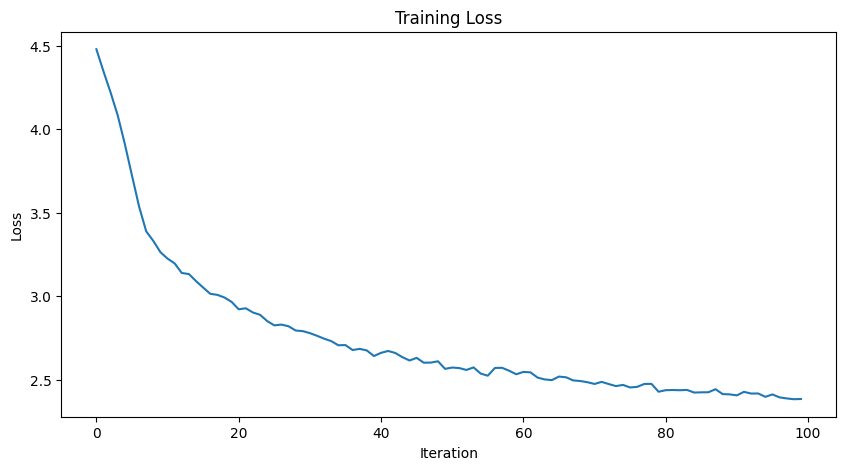

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [79]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    #feed the seed phrase, if any

    # your code here
    '''
    hidden = torch.zeros(1, 1, hidden_size).to(device)

    for i in range(max_length):
        output, hidden = model(x_sequence[:,-1:], hidden)
        probs = F.softmax(output/temperature, dim=-1)
        probs = probs.cpu().detach().numpy()
        next_token = np.random.choice(np.arange(num_tokens), p=probs.ravel())
        x_sequence = torch.cat([x_sequence, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0][1:]]).replace('<sos>', '')
    '''
    hidden = torch.zeros(1, 1, hidden_size).to(device)

    for i in range(max_length):
        output, hidden = model(x_sequence[:,-1:], hidden)
        probs = F.softmax(output/temperature, dim=-1)
        probs = probs.cpu().detach().numpy()
        next_token = np.random.choice(np.arange(num_tokens), p=probs.ravel())
        x_sequence = torch.cat([x_sequence, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=1)

    generated_text = ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0][1:]])
    generated_text = generated_text.replace('<sos>', '')
    # Дополняем или обрезаем до 500 символов
    generated_text = generated_text[:500]  # Обрезаем, если длина больше 500
    generated_text += ' ' * (500 - len(generated_text)) # Дополняем пробелами, если меньше 500

    return generated_text



    #return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [80]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

 мой дядя самых честных правилобет,
еднаяе, нрепола позалыльсяруетьсна дветьле мездляняю стращихтык карыя сторон,
и слет: е тузсаль о зномной, вольянся жалто мого мукать ей
ни вортом и дана;
вститьен,
оний
ит трых дас бамняж
полих с бернилидье этой дно готьа но дрезче скерной; влуши лиходна столь ужресь прада стоди мон ое встый,
по трамел вераюта;
кще виланижить проветья, сзанею верпое и не тевсят.




xwxxxv



xvде томновсяда бым проль. стет лить я л ем оот.

чик ив оста елих пала, стой другае


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генериуремого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [81]:
seed_phrase = ' мой дядя самых честных правил'

In [82]:
#generated_phrases = # your code here

# For example:

# generated_phrases = [
#     generate_sample(
#         model,
#         ' мой дядя самых честных правил',
#         max_length=500,
#         temperature=1.
#     ).replace('<sos>', '')
#     for _ in range(10)
# ]
temperature = 0.8
generated_phrases = [
    generate_sample(
        model,
        seed_phrase,
        max_length=500,
        temperature=temperature
    )
    for _ in range(10)
]

for phrase in generated_phrases:
    print(phrase)

 мой дядя самых честных правилитым не дседетькою чесава гравиляна в иводван.


xxvii
постугитой мылод сублоснолы бынья в сезмать прадьние кражилил и верадой дорот,
кубны.


пусьный ругде орлежть мересты ти стрибовий,
с и блевно.
и вздом,
и кове: бых новосккам
олоныть устоеньо,
те да толи мдушь, и ведовиный резе северой то пререт;
м
ою меды тахненой,
и пр скужкой бразанит проем росьсрасто перети ма булень: ллянати чтося,
астваядь нельяни таканые сареб
онноны стыл.

таша блага ердать.
пинь дуя,
оа
 мой дядя самых честных правилюбиц.
ок прочраной!)
прожел когси полат.
не востья, ивдедамил бружий преди сворь-о
прудом вораль в ворчуя мне вззазня.
потновы
поредний и малонь отолу, татри, овстиланны ородой
ель? веда:ья моет в тон, приге любы
в тав свгрет;




xxvii



xxii



xxvil
прик оннелье, ереезлинь

едсне посладно мая лобытня в люже ваям но масены в тота,
та бовдяней седолсяй.


xii



xxxxiii



xxi


ом кочах костот полелка,
и мось лом;
подругеть мугоннетьянымылья,
нго тыматка занитыб

In [83]:
# do not change the code in the block below
# __________start of block__________

if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!

Result: 1.0 / 1.0